In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [261]:
import glob
import sys
sys.path.append("/home/ppxlf2/sources/midnightoil")
from midnightoil.io.recordshandler import construct_feature_description, parse
from midnightoil.augmentation import flip, rotate, rotate90, oclusion, color, central_crop, shear_x, shear_y
augmentations=[rotate90, flip, rotate, central_crop, shear_x, shear_y, oclusion]
probs=[0.5,       0.5,    0.5,          0.4,     0.3,     0.3,      0.8]




In [262]:
files = glob.glob('/home/ppxlf2/data/SDSS2/val/val_log_128x128_shard_1-168.tfrecords')
dataset = tf.data.TFRecordDataset(files)
image_feature_description = construct_feature_description(dataset)
map_function = parse(image_feature_description, columns=['y'], with_labels=True)
dataset = dataset.map(map_function).take(10)
dataset = dataset.shuffle(10, reshuffle_each_iteration=True)
RNG = tf.random.Generator.from_seed(1331)
for f, ps in zip(augmentations, probs):
    dataset = dataset.map(lambda x, y: tf.cond(RNG.uniform((1,), 0, 1) <= ps, lambda: f(x, y), lambda: (x, y)))

dataset = dataset.batch(2, drop_remainder=True)
dataset = dataset.repeat(4)
    


<tf.Tensor: shape=(), dtype=float32, numpy=0.5522753>

In [263]:
X0 = None
X10 = None
for i, (X, y) in enumerate(dataset):
    print(i)
    
    if i == 0:
        X0 = X
        
    if i == 10:
        X10 = X

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


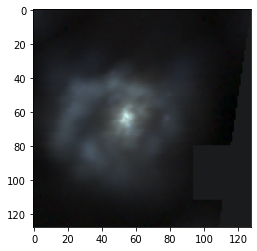

In [271]:
from matplotlib import pyplot as plt
import numpy as np
norm = np.sqrt(10**X10.numpy().copy()[0,...])
for i in range(3):
        norm[:,:,i] = (norm[:,:, i] - norm.min()) / (norm.max() - norm.min())
plt.imshow(norm)

In [2]:
import sys
sys.path.append("/home/ppxlf2/sources/midnightoil")
import tensorflow as tf

from midnightoil.io.recordshandler import construct_feature_description, parse
from midnightoil.augmentation import flip, rotate, rotate90, oclusion, color, central_crop, shear_x

import glob

RNG = tf.random.Generator.from_seed(1331)

def load_dataset(path, columns=['y'], epochs=400, training=False, shuffle=True, batch_size=128, buffer_size=18000, augmentations=[rotate90, rotate, flip, rotate, central_crop, oclusion], probs=[0.5, 0.5, 0.5, 0.8, 0.3, 0.9]):


    files = glob.glob(path)
    dataset = tf.data.TFRecordDataset(files)

    image_feature_description = construct_feature_description(dataset)
    map_function = parse(image_feature_description, columns=columns, with_labels=True)
    dataset = dataset.map(map_function)
        
    #dataset = dataset.batch(1)
    
    dataset = dataset.batch(batch_size, drop_remainder=True)

    for f, ps in zip(augmentations, probs):
        dataset = dataset.map(lambda x, y: tf.cond(RNG.uniform((1,), 0, 1) <= ps, lambda: f(x, y), lambda: (x, y)))
    
    if training:
        dataset = dataset.repeat(epochs)

    if shuffle:
        dataset = dataset.shuffle(batch_size, reshuffle_each_iteration=True)

    dataset.prefetch(buffer_size=64).cache(filename='cached.cc')
    
    return dataset


def squeeze(x, y):
    return tf.squeeze(x), y

2022-04-12 21:12:29.195181: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 21:12:30.075547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9650 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2022-04-12 21:12:30.076400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9650 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [3]:
def squeeze(x, y):
    return tf.squeeze(x), y

In [46]:
RNG.uniform((1,), 0, 1)[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.61184907>

In [3]:
dataset_X = load_dataset('/home/ppxlf2/data/SDSS2/val/val_log_128x128_shard_1-168.tfrecords', batch_size=25, training=False)

In [4]:
from midnightoil.viz.datavis import batch_mosaic

In [80]:
dataset_one = dataset_X.take(1)

In [5]:
for i, (X, y) in enumerate(dataset_X):
    1==1

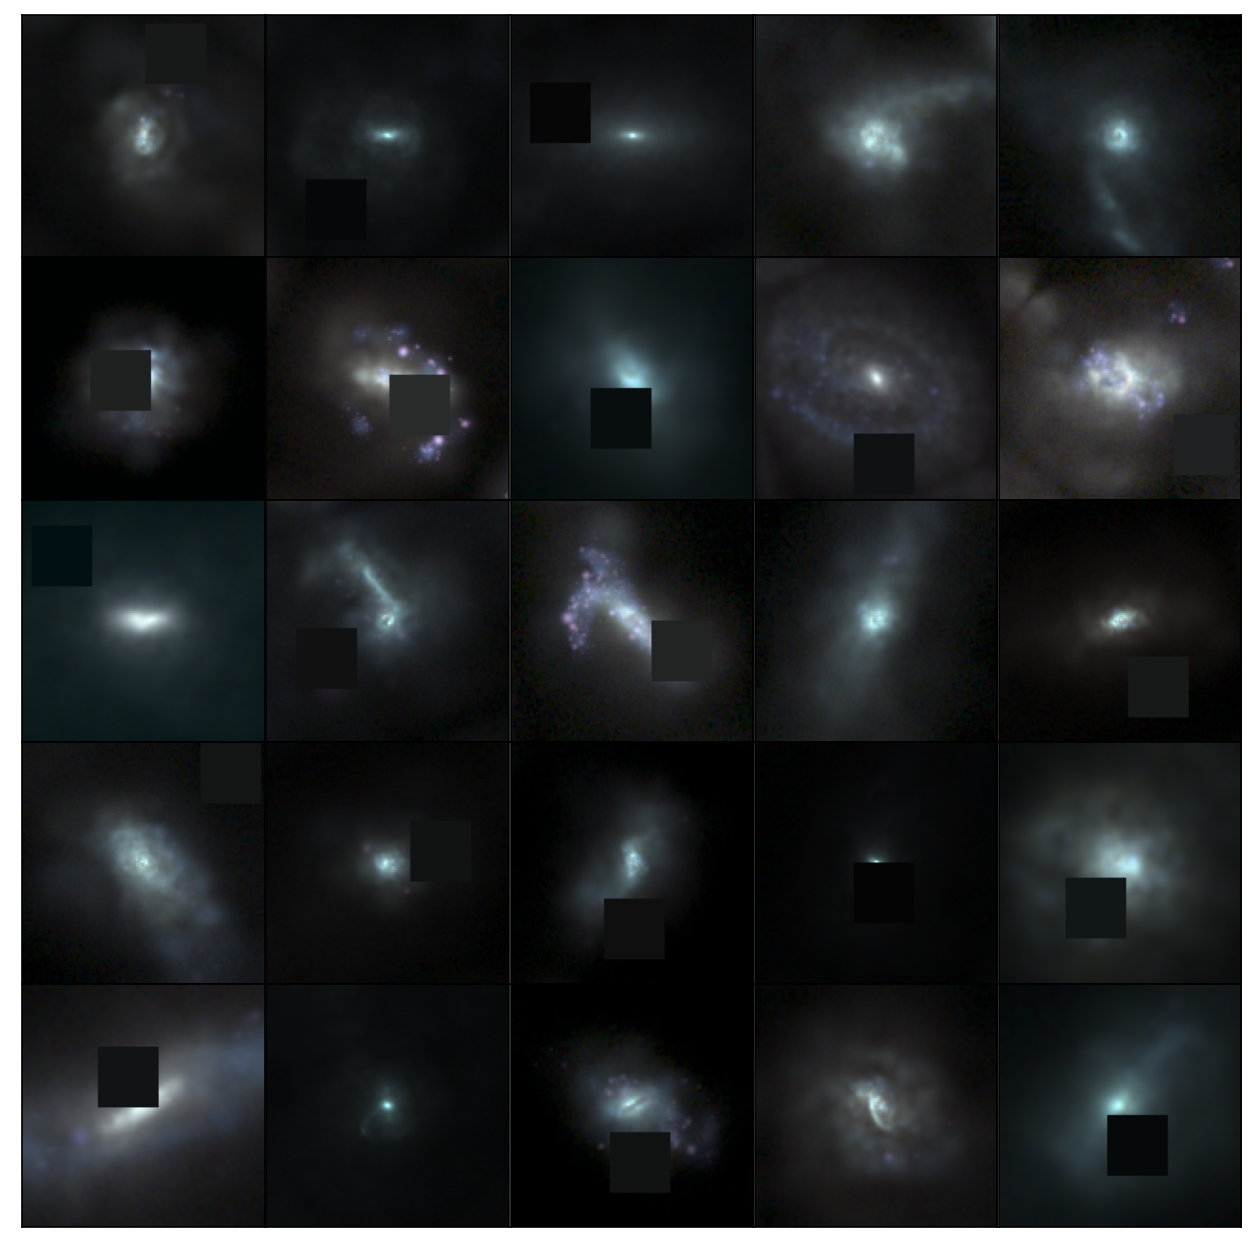

In [24]:
batch_mosaic(X)

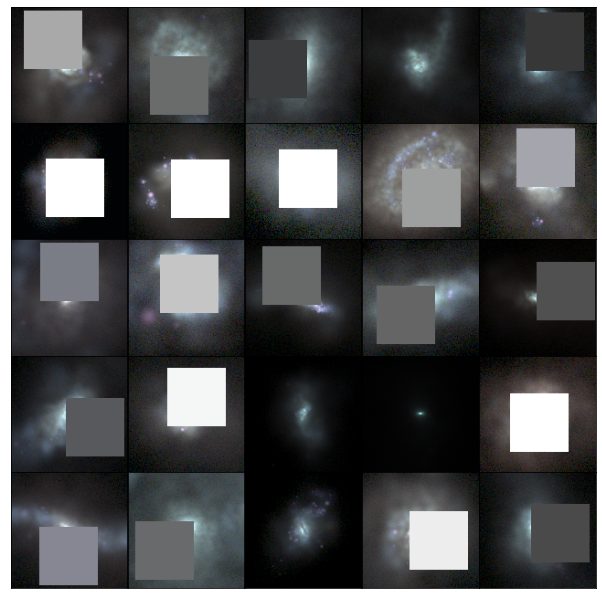

In [8]:
batch_mosaic(X)

(25, 128, 128, 3)


In [4]:
!export PYTHONPATH=/home/ppxlf2/sources/midnightoil

In [7]:
!echo $JUPYTER_PATH